In [1]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
from sodapy import Socrata
import geopandas as gpd
import requests
from pandas.io.json import json_normalize
from geopandas.tools import sjoin

In [2]:
#Creating a socrata client
# connect to the data portal
client = Socrata("data.lacity.org", None)

# First 5050 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("vt5t-mscf",
                    where = "cd = ('5')",
                     #"Locarea IN ('WILSHIRE BL', 'LINCOLN BL', '7TH ST (SP)', '7TH ST /W (SP)', '7TH ST /W', '7TH ST /E', '4TH ST', '4TH ST /W (SP)', '4TH ST /W', '4TH ST /E', '5TH ST /W (SP)', '5TH ST /W', '5TH ST /E')", 
                     #locarea ='WILSHIRE BL',#'7TH ST','4TH ST','5TH ST',
                    limit = 20000)

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)
# print it with .sample, which gives you random rows
df.sample(2)


,trees_id,trees_id2,tr_rec,locarea,locunit,locsubunit,locsite,spp,common,botanical,...,utdescription_other,curb,stock_size,sidewalk,trees_street_id,date_root_prune_curb,date_root_prune_driveway,date_root_prune_sidewalk,note_id,location_1
7212,32641,384592e81e8,326527,THAYER AV,801,F,1,304,SIBERIAN ELM,Ulmus pumila,...,NULL,NULL,NULL,NULL,360174,NULL,NULL,NULL,NULL,"{'latitude': '-118.435', 'longitude': '34.0672..."
12445,58811,384592a1152,309334,BELLAGIO RD,10644,F,11,463,PURPLE-LEAF PLUM,PRUNUS CERASIFERA,...,NULL,NULL,NULL,NULL,89888,NULL,NULL,NULL,NULL,"{'latitude': '-118.445', 'longitude': '34.0811..."


In [3]:
df['x'] = df.x.astype(float)
df['y'] = df.y.astype(float)

In [4]:
pdf = df[['trees_id','cd','common','botanical','dbh','x','y']]

In [5]:
xdf = pdf.rename(columns={'x': 'longitude', 'y': 'latitude'})

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
xdf.shape

(20000, 7)

In [8]:
new = xdf[xdf['latitude'] != 0]

In [9]:
new.shape
#should be 4543-2175-1

(17479, 7)

In [10]:
df = new
shade = df[~df['common'].str.contains('PALM')]

In [11]:
shade = shade[~shade['common'].str.contains('NULL')]
#shade.shape

In [12]:
shade = shade[~shade['common'].str.contains('OTHER')]
#shade.shape

In [13]:
shade = shade[~shade['common'].str.contains('VACANT')]
#shade.shape

In [14]:
shade = shade[~shade['common'].str.contains('STUMP')]

In [15]:


trees = gpd.GeoDataFrame(shade, 
                        crs="EPSG:4326",
                        geometry=gpd.points_from_xy(x=shade.longitude, y=shade.latitude))


In [16]:
trees.head()

,trees_id,cd,common,botanical,dbh,longitude,latitude,geometry
1,4,5,CHINESE FLAME TREE,KOELREUTERIA BIPINNATA,3-6,-118.517,34.1622,POINT (-118.51700 34.16220)
6,20,5,STRAWBERRY TREE,ARBUTUS UNEDO,NULL,-118.506,34.1666,POINT (-118.50600 34.16660)
13,45,5,ORANGE,Citrus sinensis,12-24,-118.461,34.0630,POINT (-118.46100 34.06300)
16,74,5,AVOCADO,Persea americana,3-12,-118.442,34.1319,POINT (-118.44200 34.13190)
24,98,5,CRAPE MYRTLE,LAGERSTROEMIA INDICA,0-3,-118.476,34.1554,POINT (-118.47600 34.15540)


In [17]:
trees.shape

(15742, 8)

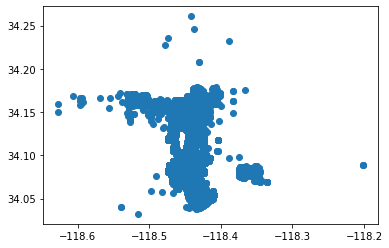

In [18]:
trees.plot()

In [19]:
# libraries

import matplotlib.pyplot as plt

# for basemaps
import contextily as ctx

In [20]:

import seaborn as sns
from pointpats import centrography
from matplotlib.patches import Ellipse
import numpy
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [21]:
# reproject the data
#stopsgdf = stopsgdf.to_crs('EPSG:3857')
trees = trees.to_crs('EPSG:3857')

In [22]:
#Because sns requires having separate x and y columns
trees['x'] = trees.geometry.x
trees['y'] = trees.geometry.y

In [23]:
trees['dbh'].dtypes

dtype('O')

In [24]:
dbh = trees.sort_values(by='dbh', ascending = False)

In [25]:
#dbh = trees[~trees['dbh'].contains('NULL')]
#dbh.head(10)

In [26]:
#by sorting by dbh, we can estimate how old and large shade trees are in CD 5. 
#the dbh ranges are not perfect so if we want to examine dbh as a shade variable, we should return to this 
#section and reorder the dbh ranges

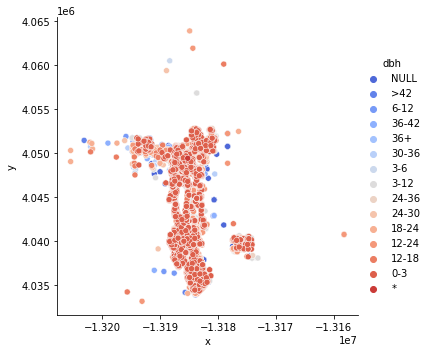

In [27]:
# to map benches by council districts
sns.relplot(data=dbh,
            x='x', 
            y='y',
            hue='dbh',
            palette='coolwarm')

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1077: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1181: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


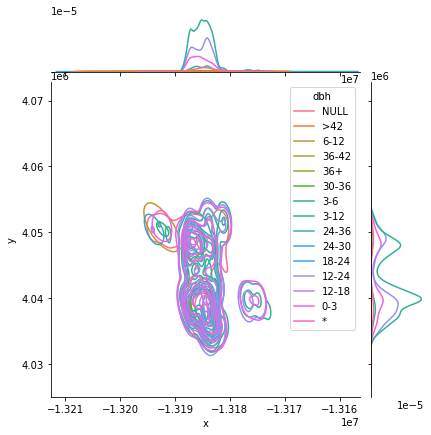

In [32]:
sns.jointplot(data=dbh,
              x='x', 
              y='y', 
              kind='kde',
             hue= 'dbh')

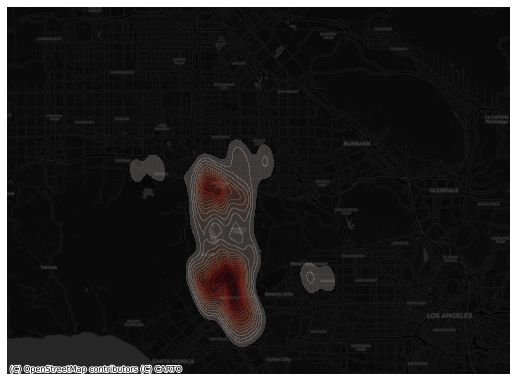

In [33]:
f, ax = plt.subplots(1, figsize=(9, 9))

# kdeplot, i.e. heat map
sns.kdeplot(x = dbh.x, 
            y = dbh.y,
            n_levels=15, 
            shade=True,
            thresh=0.05,
            alpha=0.2, 
            cmap='Reds')

# axes
ax.axis('off')

# basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)